# Rwanda Health RL Training Notebook

End-to-end experimentation pipeline for DQN, REINFORCE, PPO, and A2C on the clinic environment.

In [1]:
# Uncomment when running on a fresh Colab runtime
!pip install --quiet gymnasium stable-baselines3 sb3-contrib pygame
!pip install --quiet torch numpy pandas matplotlib seaborn

In [2]:
# Clone this repository into the Colab VM if it is not already present
import os
from pathlib import Path

REPO_URL = "https://github.com/aimee-annabelle/reinforcement-learning-ml-techniques-2-summative.git"
REPO_DIR = Path('/content') / 'reinforcement-learning-ml-techniques-2-summative'

if Path('/content').exists():
    if not REPO_DIR.exists():
        print(f"Cloning repo from {REPO_URL} to {REPO_DIR}...")
        !git clone {REPO_URL} {REPO_DIR}
    else:
        print(f"Repository already present at {REPO_DIR}")
else:
    print("/content not detected; assuming local filesystem and skipping clone.")

Repository already present at /content/reinforcement-learning-ml-techniques-2-summative


In [ ]:
# Optionally mount Google Drive for persistent artifacts when running in Colab
USE_GOOGLE_DRIVE = True  # Set to False to keep artifacts on the Colab VM
DRIVE_SUBDIR = 'rl_clinic_runs'  # Folder created inside MyDrive when persisting outputs

try:
    from google.colab import drive  # type: ignore
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    USE_GOOGLE_DRIVE = False

PERSIST_ROOT = None
if IN_COLAB and USE_GOOGLE_DRIVE:
    drive.mount('/content/drive', force_remount=False)
    from pathlib import Path
    PERSIST_ROOT = Path('/content/drive/MyDrive') / DRIVE_SUBDIR
    PERSIST_ROOT.mkdir(parents=True, exist_ok=True)
    print(f'Artifacts will be stored in: {PERSIST_ROOT}')
elif IN_COLAB:
    print('Google Drive disabled; artifacts will stay on the Colab VM (/content).')
else:
    print('Running outside Colab; using local filesystem for artifacts.')

In [3]:
# %% Import core dependencies, plotting tools, and configure paths
import os
import sys
import json
import time
import itertools
from datetime import datetime

import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces

from typing import Any, Dict, List, Optional, Tuple
from pathlib import Path

from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

import torch
from torch import nn
from torch.distributions import Categorical
from torch.nn.utils import clip_grad_norm_

import matplotlib.pyplot as plt
import seaborn as sns
# ignore warnings


sns.set_theme(style='whitegrid')

DEFAULT_REPO_NAME = 'reinforcement-learning-ml-techniques-2-summative'
PROJECT_ROOT_CANDIDATES = [
    Path.cwd(),
    Path.cwd() / DEFAULT_REPO_NAME,
    Path('/content') / DEFAULT_REPO_NAME,
    Path('/content/drive/MyDrive') / DEFAULT_REPO_NAME,
    Path.home() / DEFAULT_REPO_NAME,
    Path.home() / 'workspace' / DEFAULT_REPO_NAME,
    Path.home() / 'projects' / DEFAULT_REPO_NAME,
 ]

PROJECT_ROOT_PATH: Optional[Path] = None
for candidate in PROJECT_ROOT_CANDIDATES:
    env_dir = candidate / 'environment'
    if env_dir.exists():
        PROJECT_ROOT_PATH = candidate.resolve()
        break

if PROJECT_ROOT_PATH is None:
    raise FileNotFoundError(
        "Could not locate the 'environment' package. "
        "If you are running in Colab, clone or upload this repository so that the 'environment' folder is available. "
        "Example: !git clone https://github.com/aimee-annabelle/reinforcement-learning-ml-techniques-2-summative.git"
    )

os.chdir(PROJECT_ROOT_PATH)
if str(PROJECT_ROOT_PATH) not in sys.path:
    sys.path.append(str(PROJECT_ROOT_PATH))

PROJECT_ROOT = str(PROJECT_ROOT_PATH)

if 'PERSIST_ROOT' in globals() and PERSIST_ROOT is not None:
    ARTIFACT_ROOT = Path(PERSIST_ROOT).resolve()
else:
    ARTIFACT_ROOT = PROJECT_ROOT_PATH

ARTIFACT_ROOT = Path(ARTIFACT_ROOT).resolve()
ARTIFACT_ROOT_STR = str(ARTIFACT_ROOT)

MODEL_DIR = str(ARTIFACT_ROOT / 'models')
RESULTS_DIR = str(ARTIFACT_ROOT / 'results')
LOG_DIR = str(ARTIFACT_ROOT / 'logs')

for subdir in [MODEL_DIR, RESULTS_DIR, LOG_DIR]:
    os.makedirs(subdir, exist_ok=True)

for algo_name in ['dqn', 'ppo', 'a2c', 'reinforce']:
    os.makedirs(os.path.join(MODEL_DIR, algo_name), exist_ok=True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using project root: {PROJECT_ROOT}')
print(f'Artifacts root: {ARTIFACT_ROOT_STR}')
print(f'Using device: {DEVICE}')

Using project root: /content/reinforcement-learning-ml-techniques-2-summative
Using device: cuda


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [4]:
# %% Import shared Rwanda clinic environment used by DQN, PPO, A2C, and REINFORCE
from environment.custom_env import (
    RwandaHealthEnv,
    ACTION_MEANINGS,
    REQUEST_NCD_TEST,
    REQUEST_INFECTION_TEST,
    DIAGNOSE_CHRONIC,
    DIAGNOSE_INFECTION,
    ALLOCATE_MED,
    REFER_PATIENT,
    WAIT,
    make_env as _base_make_env,
    CONDITION_HEALTHY_OR_MILD,
    CONDITION_CHRONIC,
    CONDITION_INFECTION,
    CONDITION_BOTH_SERIOUS,
    )

/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

In [5]:
# %% Evaluation helpers and bookkeeping for all algorithms
experiment_runs: List[Dict[str, Any]] = []

def make_env(seed: Optional[int] = None, render_mode: Optional[str] = None, monitor: bool = True):
    return _base_make_env(seed=seed, render_mode=render_mode, monitor=monitor)

def evaluate_sb3_model(model, eval_episodes: int = 20, seed: int = 10_000) -> Tuple[float, float]:
    eval_env = make_env(seed=seed, monitor=False)()
    mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=eval_episodes, deterministic=True)
    eval_env.close()
    return float(mean_reward), float(std_reward)

def evaluate_reinforce_policy(policy: nn.Module, eval_episodes: int = 20, seed: int = 20_000) -> Tuple[float, float]:
    policy.eval()
    rewards: List[float] = []
    for episode in range(eval_episodes):
        env = make_env(seed=seed + episode, monitor=False)()
        obs, _ = env.reset(seed=seed + episode)
        terminated = False
        truncated = False
        episode_reward = 0.0
        while not (terminated or truncated):
            obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=DEVICE)
            with torch.no_grad():
                logits = policy(obs_tensor)
            action = int(torch.argmax(logits).item())
            obs, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
        env.close()
        rewards.append(episode_reward)
    policy.train()
    return float(np.mean(rewards)), float(np.std(rewards))

def record_result(
    algorithm: str,
    run_id: int,
    seed: int,
    params: Dict[str, Any],
    mean_reward: float,
    std_reward: float,
    metadata: Optional[Dict[str, Any]] = None,
 ) -> None:
    run_record = {
        'algorithm': algorithm,
        'run_id': run_id,
        'seed': seed,
        'mean_reward': mean_reward,
        'std_reward': std_reward,
        'hyperparameters': dict(params),
    }
    if metadata:
        run_record.update(metadata)
    experiment_runs.append(run_record)

dummy_env = RwandaHealthEnv()
OBS_DIM = dummy_env.observation_space.shape[0]
ACT_DIM = dummy_env.action_space.n
dummy_env.close()
del dummy_env
print(f'Observation dim: {OBS_DIM}, action dim: {ACT_DIM}')

Observation dim: 12, action dim: 7


In [6]:
# %% Hyperparameter grids for DQN, PPO, A2C, and REINFORCE sweeps
def build_dqn_grid() -> List[Dict[str, Any]]:
    combos = list(itertools.product(
        [1e-3, 5e-4, 3e-4],
        [0.95, 0.98, 0.99],
        [4096, 8192, 16384],
        [32, 64, 128],
        [1, 4, 8],
        [500, 750, 1000],
        [0.2, 0.3],
        [0.01, 0.02],
    ))
    grid: List[Dict[str, Any]] = []
    for combo in combos:
        lr, gamma, buffer_size, batch_size, train_freq, target_update_interval, exploration_fraction, exploration_final_eps = combo
        grid.append({
            'learning_rate': lr,
            'gamma': gamma,
            'buffer_size': buffer_size,
            'batch_size': batch_size,
            'train_freq': train_freq,
            'target_update_interval': target_update_interval,
            'exploration_fraction': exploration_fraction,
            'exploration_final_eps': exploration_final_eps,
        })
        if len(grid) >= 12:
            break
    return grid

def build_ppo_grid() -> List[Dict[str, Any]]:
    combos = list(itertools.product(
        [3e-4, 1e-4, 5e-4],
        [0.95, 0.98, 0.99],
        [1024, 2048, 3072],
        [64, 128, 256],
        [3, 5, 10],
        [0.9, 0.95, 0.99],
        [0.1, 0.2, 0.3],
    ))
    grid: List[Dict[str, Any]] = []
    for combo in combos:
        lr, gamma, n_steps, batch_size, n_epochs, gae_lambda, clip_range = combo
        if batch_size > n_steps:
            continue
        grid.append({
            'learning_rate': lr,
            'gamma': gamma,
            'n_steps': n_steps,
            'batch_size': batch_size,
            'n_epochs': n_epochs,
            'gae_lambda': gae_lambda,
            'clip_range': clip_range,
        })
        if len(grid) >= 12:
            break
    return grid

def build_a2c_grid() -> List[Dict[str, Any]]:
    combos = list(itertools.product(
        [7e-4, 5e-4, 3e-4],
        [0.95, 0.98, 0.99],
        [0.9, 0.95, 0.99],
        [5, 10, 20],
        [0.0, 0.01, 0.05],
    ))
    grid: List[Dict[str, Any]] = []
    for combo in combos:
        lr, gamma, gae_lambda, n_steps, ent_coef = combo
        grid.append({
            'learning_rate': lr,
            'gamma': gamma,
            'gae_lambda': gae_lambda,
            'n_steps': n_steps,
            'ent_coef': ent_coef,
        })
        if len(grid) >= 12:
            break
    return grid

def build_reinforce_grid() -> List[Dict[str, Any]]:
    combos = list(itertools.product(
        [1e-3, 5e-4, 3e-4],
        [0.95, 0.98, 0.99],
        [(128, 128), (256, 128), (256, 256), (128, 64)],
        [0.0, 0.01, 0.02],
        [0.5, 1.0],
        [20, 30, 40],
    ))
    grid: List[Dict[str, Any]] = []
    for combo in combos:
        lr, gamma, hidden_layers, entropy_coef, max_grad_norm, log_interval = combo
        grid.append({
            'learning_rate': lr,
            'gamma': gamma,
            'hidden_layers': hidden_layers,
            'entropy_coef': entropy_coef,
            'max_grad_norm': max_grad_norm,
            'log_interval': log_interval,
        })
        if len(grid) >= 12:
            break
    return grid

DQN_PARAM_GRID = build_dqn_grid()
PPO_PARAM_GRID = build_ppo_grid()
A2C_PARAM_GRID = build_a2c_grid()
REINFORCE_PARAM_GRID = build_reinforce_grid()

print(f'DQN grid size: {len(DQN_PARAM_GRID)}')
print(f'PPO grid size: {len(PPO_PARAM_GRID)}')
print(f'A2C grid size: {len(A2C_PARAM_GRID)}')
print(f'REINFORCE grid size: {len(REINFORCE_PARAM_GRID)}')

DQN grid size: 12
PPO grid size: 12
A2C grid size: 12
REINFORCE grid size: 12


In [7]:
# %% Training horizon configuration shared by all algorithms
TOTAL_TIMESTEPS = {
    'dqn': 200_000,
    'ppo': 600_000,
    'a2c': 400_000,
}

REINFORCE_EPISODES = 800
EVAL_EPISODES = 20
BASE_SEED = 2024

print('Timesteps per algorithm:', TOTAL_TIMESTEPS)
print(f'Reinforce episodes: {REINFORCE_EPISODES}, evaluation episodes: {EVAL_EPISODES}')

Timesteps per algorithm: {'dqn': 200000, 'ppo': 600000, 'a2c': 400000}
Reinforce episodes: 800, evaluation episodes: 20


In [8]:
def run_sb3_experiments(
    algo_name: str,
    algo_cls,
    param_grid: List[Dict[str, Any]],
    total_timesteps: int,
    eval_episodes: int = EVAL_EPISODES,
    base_seed: int = BASE_SEED,
 ) -> None:
    print(f'Starting {algo_name.upper()} experiments ({len(param_grid)} runs)...')
    for run_idx, params in enumerate(param_grid):
        run_seed = base_seed + run_idx
        set_random_seed(run_seed)
        env = DummyVecEnv([make_env(seed=run_seed, monitor=True)])
        log_dir = os.path.join(LOG_DIR, algo_name, f'run_{run_idx:02d}')
        os.makedirs(log_dir, exist_ok=True)
        model = algo_cls('MlpPolicy', env, verbose=0, tensorboard_log=log_dir, seed=run_seed, **params)
        start_time = time.time()
        try:
            model.learn(total_timesteps=total_timesteps, progress_bar=True)
        except TypeError:
            model.learn(total_timesteps=total_timesteps)
        duration = time.time() - start_time
        mean_reward, std_reward = evaluate_sb3_model(model, eval_episodes=eval_episodes, seed=run_seed + 10_000)
        model_path = os.path.join(MODEL_DIR, algo_name, f'{algo_name}_run_{run_idx:02d}')
        model.save(model_path)
        env.close()
        record_result(
            algorithm=algo_name,
            run_id=run_idx,
            seed=run_seed,
            params=params,
            mean_reward=mean_reward,
            std_reward=std_reward,
            metadata={'duration_sec': duration, 'timesteps': total_timesteps, 'model_path': model_path},
        )
        print(f'Run {run_idx:02d} -> mean reward {mean_reward:.2f} ± {std_reward:.2f} (saved to {model_path})')

In [9]:
# %% Launch DQN experiments (set RUN_DQN = True before executing)
RUN_DQN = True
if RUN_DQN:
    run_sb3_experiments(
        algo_name='dqn',
        algo_cls=DQN,
        param_grid=DQN_PARAM_GRID,
        total_timesteps=TOTAL_TIMESTEPS['dqn'],
        eval_episodes=EVAL_EPISODES,
        base_seed=BASE_SEED,
    )

Starting DQN experiments (12 runs)...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Output()

Run 00 -> mean reward 164.91 ± 52.99 (saved to /content/reinforcement-learning-ml-techniques-2-summative/models/dqn/dqn_run_00)


Output()

Run 01 -> mean reward 151.44 ± 41.06 (saved to /content/reinforcement-learning-ml-techniques-2-summative/models/dqn/dqn_run_01)


Output()

Run 02 -> mean reward 132.27 ± 60.85 (saved to /content/reinforcement-learning-ml-techniques-2-summative/models/dqn/dqn_run_02)


Output()

Run 03 -> mean reward 128.98 ± 59.03 (saved to /content/reinforcement-learning-ml-techniques-2-summative/models/dqn/dqn_run_03)


Output()

Run 04 -> mean reward 124.01 ± 45.73 (saved to /content/reinforcement-learning-ml-techniques-2-summative/models/dqn/dqn_run_04)


Output()

Run 05 -> mean reward 121.56 ± 75.12 (saved to /content/reinforcement-learning-ml-techniques-2-summative/models/dqn/dqn_run_05)


Output()

Run 06 -> mean reward 120.12 ± 56.75 (saved to /content/reinforcement-learning-ml-techniques-2-summative/models/dqn/dqn_run_06)


Output()

Run 07 -> mean reward 152.62 ± 39.71 (saved to /content/reinforcement-learning-ml-techniques-2-summative/models/dqn/dqn_run_07)


Output()

Run 08 -> mean reward 120.09 ± 72.97 (saved to /content/reinforcement-learning-ml-techniques-2-summative/models/dqn/dqn_run_08)


Output()

Run 09 -> mean reward 143.74 ± 47.04 (saved to /content/reinforcement-learning-ml-techniques-2-summative/models/dqn/dqn_run_09)


Output()

Run 10 -> mean reward 110.37 ± 60.88 (saved to /content/reinforcement-learning-ml-techniques-2-summative/models/dqn/dqn_run_10)


Run 11 -> mean reward 118.69 ± 70.95 (saved to /content/reinforcement-learning-ml-techniques-2-summative/models/dqn/dqn_run_11)


In [10]:
# %% Launch PPO experiments (set RUN_PPO = True before executing)
RUN_PPO = False
if RUN_PPO:
    run_sb3_experiments(
        algo_name='ppo',
        algo_cls=PPO,
        param_grid=PPO_PARAM_GRID,
        total_timesteps=TOTAL_TIMESTEPS['ppo'],
        eval_episodes=EVAL_EPISODES,
        base_seed=BASE_SEED + 500,
    )

In [11]:
# %% Launch A2C experiments (set RUN_A2C = True before executing)
RUN_A2C = False
if RUN_A2C:
    run_sb3_experiments(
        algo_name='a2c',
        algo_cls=A2C,
        param_grid=A2C_PARAM_GRID,
        total_timesteps=TOTAL_TIMESTEPS['a2c'],
        eval_episodes=EVAL_EPISODES,
        base_seed=BASE_SEED + 1_000,
    )

In [12]:
# %% Define REINFORCE policy network and training loop
class ReinforceNetwork(nn.Module):
    def __init__(self, obs_dim: int, act_dim: int, hidden_layers: Tuple[int, ...]):
        super().__init__()
        layers: List[nn.Module] = []
        input_dim = obs_dim
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        layers.append(nn.Linear(input_dim, act_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

def train_reinforce(
    param_grid: List[Dict[str, Any]],
    total_episodes: int = REINFORCE_EPISODES,
    eval_episodes: int = EVAL_EPISODES,
    base_seed: int = BASE_SEED + 2_000,
 ) -> None:
    print(f'Starting REINFORCE experiments ({len(param_grid)} runs)...')
    for run_idx, params in enumerate(param_grid):
        run_seed = base_seed + run_idx
        set_random_seed(run_seed)
        np.random.seed(run_seed)
        torch.manual_seed(run_seed)
        env = make_env(seed=run_seed, monitor=False)()
        policy = ReinforceNetwork(OBS_DIM, ACT_DIM, params['hidden_layers']).to(DEVICE)
        policy.train()
        optimizer = torch.optim.Adam(policy.parameters(), lr=params['learning_rate'])
        gamma = params['gamma']
        entropy_coef = params.get('entropy_coef', 0.0)
        max_grad_norm = params.get('max_grad_norm', 1.0)
        log_interval = params.get('log_interval', 20)
        episode_rewards: List[float] = []
        start_time = time.time()
        for episode in range(total_episodes):
            log_probs: List[torch.Tensor] = []
            entropies: List[torch.Tensor] = []
            rewards: List[float] = []
            obs, _ = env.reset(seed=run_seed + episode)
            terminated = False
            truncated = False
            while not (terminated or truncated):
                obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=DEVICE)
                dist = Categorical(logits=policy(obs_tensor))
                action = dist.sample()
                log_probs.append(dist.log_prob(action))
                entropies.append(dist.entropy())
                obs, reward, terminated, truncated, _ = env.step(int(action.item()))
                rewards.append(reward)
            returns: List[float] = []
            discounted_return = 0.0
            for reward in reversed(rewards):
                discounted_return = reward + gamma * discounted_return
                returns.insert(0, discounted_return)
            returns_tensor = torch.as_tensor(returns, dtype=torch.float32, device=DEVICE)
            normalized_returns = (returns_tensor - returns_tensor.mean()) / (returns_tensor.std() + 1e-8)
            log_prob_tensor = torch.stack(log_probs)
            entropy_tensor = torch.stack(entropies)
            loss = -(normalized_returns.detach() * log_prob_tensor).sum()
            if entropy_coef > 0.0:
                loss -= entropy_coef * entropy_tensor.sum()
            optimizer.zero_grad()
            loss.backward()
            if max_grad_norm is not None:
                clip_grad_norm_(policy.parameters(), max_grad_norm)
            optimizer.step()
            episode_reward = float(np.sum(rewards))
            episode_rewards.append(episode_reward)
            if (episode + 1) % log_interval == 0:
                rolling = float(np.mean(episode_rewards[-log_interval:]))
                print(f'Run {run_idx:02d} | Episode {episode + 1} | rolling reward {rolling:.2f}')
        duration = time.time() - start_time
        mean_reward, std_reward = evaluate_reinforce_policy(policy, eval_episodes=eval_episodes, seed=run_seed + 30_000)
        model_path = os.path.join(MODEL_DIR, 'reinforce', f'reinforce_run_{run_idx:02d}.pt')
        torch.save({'state_dict': policy.state_dict(), 'hyperparameters': dict(params)}, model_path)
        env.close()
        record_result(
            algorithm='reinforce',
            run_id=run_idx,
            seed=run_seed,
            params=params,
            mean_reward=mean_reward,
            std_reward=std_reward,
            metadata={'duration_sec': duration, 'episodes': total_episodes, 'model_path': model_path},
        )
        print(f'Run {run_idx:02d} -> mean reward {mean_reward:.2f} ± {std_reward:.2f} (saved to {model_path})')

In [13]:
# %% Launch REINFORCE experiments (set RUN_REINFORCE = True before executing)
RUN_REINFORCE = False
if RUN_REINFORCE:
    train_reinforce(
        param_grid=REINFORCE_PARAM_GRID,
        total_episodes=REINFORCE_EPISODES,
        eval_episodes=EVAL_EPISODES,
        base_seed=BASE_SEED + 4_000,
    )

In [14]:
# %% Summarize recorded runs for DQN, PPO, A2C, and REINFORCE
if experiment_runs:
    results_df = pd.DataFrame(experiment_runs)
    results_df = results_df.sort_values(by='mean_reward', ascending=False).reset_index(drop=True)
    display(results_df)
else:
    print('No experiments recorded yet. Enable one of the RUN_* toggles and re-run.')

,algorithm,run_id,seed,mean_reward,std_reward,hyperparameters,duration_sec,timesteps,model_path
0,dqn,0,2024,164.909997,52.987425,"{'learning_rate': 0.001, 'gamma': 0.95, 'buffe...",697.569526,200000,/content/reinforcement-learning-ml-techniques-...
1,dqn,7,2031,152.616663,39.705246,"{'learning_rate': 0.001, 'gamma': 0.95, 'buffe...",686.418480,200000,/content/reinforcement-learning-ml-techniques-...
2,dqn,1,2025,151.436664,41.063876,"{'learning_rate': 0.001, 'gamma': 0.95, 'buffe...",685.240329,200000,/content/reinforcement-learning-ml-techniques-...
3,dqn,9,2033,143.736664,47.043365,"{'learning_rate': 0.001, 'gamma': 0.95, 'buffe...",678.046581,200000,/content/reinforcement-learning-ml-techniques-...
4,dqn,2,2026,132.268331,60.845628,"{'learning_rate': 0.001, 'gamma': 0.95, 'buffe...",674.017180,200000,/content/reinforcement-learning-ml-techniques-...
5,dqn,3,2027,128.976664,59.027734,"{'learning_rate': 0.001, 'gamma': 0.95, 'buffe...",670.053678,200000,/content/reinforcement-learning-ml-techniques-...
6,dqn,4,2028,124.011664,45.730116,"{'learning_rate': 0.001, 'gamma': 0.95, 'buffe...",676.217613,200000,/content/reinforcement-learning-ml-techniques-...
7,dqn,5,2029,121.564998,75.116917,"{'learning_rate': 0.001, 'gamma': 0.95, 'buffe...",677.725286,200000,/content/reinforcement-learning-ml-techniques-...
8,dqn,6,2030,120.119998,56.752847,"{'learning_rate': 0.001, 'gamma': 0.95, 'buffe...",681.229692,200000,/content/reinforcement-learning-ml-techniques-...
9,dqn,8,2032,120.093331,72.974817,"{'learning_rate': 0.001, 'gamma': 0.95, 'buffe...",688.575102,200000,/content/reinforcement-learning-ml-techniques-...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


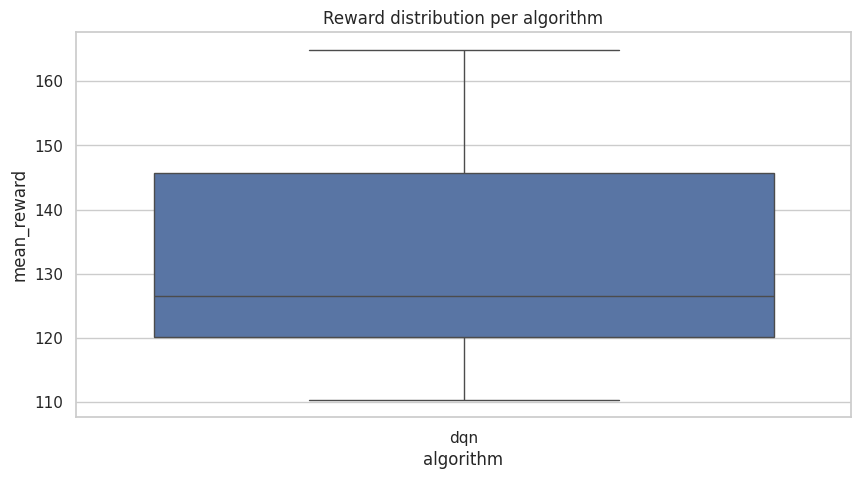

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


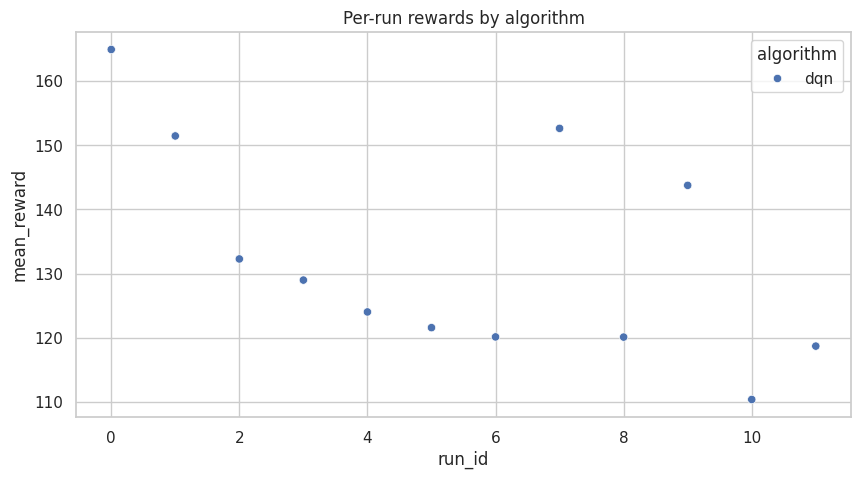

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [15]:
# %% Visualize reward distributions across algorithms
if experiment_runs:
    results_df = pd.DataFrame(experiment_runs)
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=results_df, x='algorithm', y='mean_reward')
    plt.title('Reward distribution per algorithm')
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=results_df, x='run_id', y='mean_reward', hue='algorithm', style='algorithm')
    plt.title('Per-run rewards by algorithm')
    plt.show()
else:
    print('No results to visualize yet.')

In [16]:
# %% Export aggregated results to CSV
if experiment_runs:
    results_df = pd.DataFrame(experiment_runs)
    timestamp = datetime.utcnow().strftime('%Y%m%d_%H%M%S')
    csv_path = os.path.join(RESULTS_DIR, f'rl_experiment_results_{timestamp}.csv')
    results_df.to_csv(csv_path, index=False)
    print(f'Results saved to {csv_path}')
else:
    print('Run at least one experiment before exporting results.')

Results saved to /content/reinforcement-learning-ml-techniques-2-summative/results/rl_experiment_results_20251123_160219.csv


/tmp/ipython-input-2749195102.py:4: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().strftime('%Y%m%d_%H%M%S')


In [ ]:
# %% Load saved DQN/PPO/A2C models or REINFORCE checkpoints for evaluation
def load_and_evaluate_sb3_model(model_path: str, eval_episodes: int = EVAL_EPISODES) -> None:
    if not os.path.exists(model_path) and os.path.exists(f'{model_path}.zip'):
        model_path = f'{model_path}.zip'
    model_path_lower = model_path.lower()
    if 'dqn' in model_path_lower:
        model = DQN.load(model_path)
    elif 'ppo' in model_path_lower:
        model = PPO.load(model_path)
    elif 'a2c' in model_path_lower:
        model = A2C.load(model_path)
    else:
        raise ValueError('Unsupported SB3 model path. Include algo name in filename.')
    mean_reward, std_reward = evaluate_sb3_model(model, eval_episodes=eval_episodes, seed=BASE_SEED + 50_000)
    print(f'Loaded {model.__class__.__name__} -> mean reward {mean_reward:.2f} ± {std_reward:.2f}')

def evaluate_saved_reinforce(model_path: str, eval_episodes: int = EVAL_EPISODES) -> None:
    payload = torch.load(model_path, map_location=DEVICE)
    params = payload.get('hyperparameters', {'hidden_layers': (128, 128)})
    hidden_layers = tuple(params.get('hidden_layers', (128, 128)))
    policy = ReinforceNetwork(OBS_DIM, ACT_DIM, hidden_layers).to(DEVICE)
    policy.load_state_dict(payload['state_dict'])
    mean_reward, std_reward = evaluate_reinforce_policy(policy, eval_episodes=eval_episodes, seed=BASE_SEED + 60_000)
    print(f'Loaded REINFORCE policy -> mean reward {mean_reward:.2f} ± {std_reward:.2f}')

# Helpers to move artifacts off the Colab VM after training
def backup_artifacts_to_drive(dest_subdir: str = 'rl_artifacts') -> None:
    try:
        from google.colab import drive  # type: ignore
    except ImportError:
        print('Colab runtime not detected; skipping Google Drive backup.')
        return
    drive.mount('/content/drive', force_remount=False)
    from pathlib import Path
    import shutil

    dest_root = Path('/content/drive/MyDrive') / dest_subdir
    dest_root.mkdir(parents=True, exist_ok=True)

    artifact_root = Path(ARTIFACT_ROOT_STR if 'ARTIFACT_ROOT_STR' in globals() else PROJECT_ROOT)
    if artifact_root.resolve() == dest_root.resolve():
        print(f'Artifacts already stored in {dest_root}; no copy performed.')
        return

    include_map = {
        'models': Path(MODEL_DIR),
        'logs': Path(LOG_DIR),
        'results': Path(RESULTS_DIR),
    }
    for folder, base_path in include_map.items():
        if not base_path.exists():
            print(f'Skipping missing {base_path}')
            continue
        target = dest_root / folder
        shutil.copytree(base_path, target, dirs_exist_ok=True)
        print(f'Copied {base_path} -> {target}')
    print('Artifacts copied to Google Drive. You can download them from the Drive UI.')

def create_artifact_zip(zip_name: str = 'rl_artifacts.zip', include_logs: bool = True) -> str:
    from pathlib import Path
    from zipfile import ZipFile, ZIP_DEFLATED

    zip_name = zip_name if zip_name.endswith('.zip') else f'{zip_name}.zip'
    results_path = Path(RESULTS_DIR)
    export_dir = results_path / 'exports'
    export_dir.mkdir(parents=True, exist_ok=True)
    archive_path = export_dir / zip_name
    if archive_path.exists():
        archive_path.unlink()

    artifact_root = Path(ARTIFACT_ROOT_STR if 'ARTIFACT_ROOT_STR' in globals() else PROJECT_ROOT)

    include_map = {
        'models': Path(MODEL_DIR),
        'results': results_path,
    }
    if include_logs:
        include_map['logs'] = Path(LOG_DIR)

    files_to_add = []
    for folder, base_path in include_map.items():
        if not base_path.exists():
            print(f'Skipping missing {base_path}')
            continue
        skip_exports = folder == 'results'
        for src_path in base_path.rglob('*'):
            if not src_path.is_file():
                continue
            if skip_exports and export_dir in src_path.parents:
                continue
            try:
                rel_path = src_path.relative_to(artifact_root)
            except ValueError:
                rel_path = Path(folder) / src_path.name
            files_to_add.append((src_path, rel_path))

    if not files_to_add:
        raise FileNotFoundError('No artifact files found to include in the zip archive.')

    with ZipFile(archive_path, 'w', ZIP_DEFLATED) as zip_file:
        for src_path, rel_path in files_to_add:
            zip_file.write(src_path, arcname=str(rel_path))
    print(f'Created zip archive at {archive_path}.')
    return str(archive_path)

def download_artifacts(zip_name: str = 'rl_artifacts.zip', include_logs: bool = True) -> None:
    archive_path = create_artifact_zip(zip_name, include_logs=include_logs)
    try:
        from google.colab import files  # type: ignore
    except ImportError:
        print(f'Zip ready at {archive_path}. Copy it from your local filesystem.')
        return
    files.download(archive_path)
    print('Download started. Keep the tab open until the file is saved locally.')

In [ ]:
download_artifacts('my_runs.zip')